# Data Wrangling: Acquisition & Preparation

## Example Goals

Improve Zestimate log error prediction model by using clusters that include location as a feature for the model.  

## Learning Goals
    
- Acquire a sample of data from SQL
- Identify null values, which nulls are 'deal-breakers', i.e. rows removed, which nulls should be represented by 0, and which should be replaced by a value from other methods, such as mean.		
- Identify outliers and decide what to do with them, if anything.  (remove, keep as-is, replace)
- Data Structure:  Aggregate as needed so that every row is an observation and each column is a variable (1 variable and not a measure). 


## Demonstrating

*information about the examples we will be using*

1. Prepare the environment
2. Summarize the Data
3. Missing Values
4. Outliers
5. Tidy the data

### 1. Prepare the environment

In [63]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split

pd.options.display.float_format = '{:20,.2f}'.format
%matplotlib inline

seed = 123

In [23]:
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


df = pd.read_sql('''
                 SELECT p2.parcelid, p2.bathroomcnt, p2.bedroomcnt, p2.calculatedfinishedsquarefeet, p2.latitude, 
                 p2.longitude, p2.fips, p2.regionidcounty, p2.regionidzip, p2.yearbuilt, p2.taxvaluedollarcnt, 
                 p2.landtaxvaluedollarcnt, p1.logerror, p1.transactiondate
                    FROM predictions_2016 p1
                    LEFT JOIN properties_2016 p2  USING(parcelid)
                    WHERE bedroomcnt > 0 AND bathroomcnt > 0 AND unitcnt = 1 
                    AND latitude IS NOT NULL AND longitude IS NOT NULL;
                    '''
                 , get_connection('zillow'))

df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,fips,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror,transactiondate
0,11016594,2.00,3.00,"1,684.00","34,280,990.00","-118,488,536.00","6,037.00","3,101.00","96,370.00","1,959.00","360,170.00","237,416.00",0.03,2016-01-01
1,12098116,3.00,2.00,"2,217.00","34,136,312.00","-118,175,032.00","6,037.00","3,101.00","96,293.00","1,940.00","119,906.00","57,912.00",-0.00,2016-01-01
2,12643413,2.00,2.00,839.00,"33,755,800.00","-118,309,000.00","6,037.00","3,101.00","96,222.00","1,987.00","244,880.00","73,362.00",0.02,2016-01-02
3,11509835,4.00,4.00,"3,067.00","33,870,089.00","-118,402,768.00","6,037.00","3,101.00","96,109.00","1,982.00","2,447,951.00","1,567,301.00",-0.27,2016-01-02
4,12286022,1.00,2.00,"1,297.00","33,899,475.00","-118,212,720.00","6,037.00","3,101.00","96,091.00","1,939.00","111,521.00","46,972.00",0.04,2016-01-02


_________________________________________

### 2. Summarize the Data

In [24]:
df.shape

(54233, 14)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54233 entries, 0 to 54232
Data columns (total 14 columns):
parcelid                        54233 non-null int64
bathroomcnt                     54233 non-null float64
bedroomcnt                      54233 non-null float64
calculatedfinishedsquarefeet    54231 non-null float64
latitude                        54233 non-null float64
longitude                       54233 non-null float64
fips                            54233 non-null float64
regionidcounty                  54233 non-null float64
regionidzip                     54233 non-null float64
yearbuilt                       54221 non-null float64
taxvaluedollarcnt               54233 non-null float64
landtaxvaluedollarcnt           54233 non-null float64
logerror                        54233 non-null float64
transactiondate                 54233 non-null object
dtypes: float64(12), int64(1), object(1)
memory usage: 5.8+ MB


In [26]:
# df.describe(include='all')
df.describe()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,fips,regionidcounty,regionidzip,yearbuilt,taxvaluedollarcnt,landtaxvaluedollarcnt,logerror
count,"54,233.00","54,233.00","54,233.00","54,231.00","54,233.00","54,233.00","54,233.00","54,233.00","54,233.00","54,221.00","54,233.00","54,233.00","54,233.00"
mean,"11,856,953.30",2.23,2.96,"1,689.03","34,108,540.11","-118,260,984.75","6,037.00","3,100.90","96,409.15","1,964.65","439,833.83","263,596.10",0.01
std,"725,031.87",0.99,0.99,889.29,"218,609.73","221,959.13",0.16,13.50,"4,523.06",24.23,"577,136.85","411,424.92",0.16
min,"10,711,738.00",1.00,1.00,66.00,"33,339,295.00","-118,908,236.00","6,037.00","1,286.00","95,982.00","1,885.00",22.00,22.00,-4.61
25%,"11,182,713.00",2.00,2.00,"1,141.00","33,963,244.00","-118,427,000.00","6,037.00","3,101.00","96,124.00","1,950.00","179,024.00","62,806.00",-0.03
50%,"11,844,716.00",2.00,3.00,"1,472.00","34,090,900.00","-118,282,075.00","6,037.00","3,101.00","96,292.00","1,962.00","315,147.00","168,994.00",0.01
75%,"12,519,383.00",3.00,4.00,"1,965.00","34,192,600.00","-118,109,487.00","6,037.00","3,101.00","96,424.00","1,984.00","509,000.00","320,760.00",0.04
max,"13,878,705.00",20.00,16.00,"20,013.00","34,816,009.00","-117,652,146.00","6,059.00","3,101.00","399,675.00","2,015.00","27,750,000.00","24,500,000.00",4.74


### 3. Missing Values

1. Missing values by column: Does the attribute have enough information (i.e. enought non-null values) to be useful?

2. Missing values by row:  Does the observation have enough information to use in our sample? 

#### Missing Values by Column

In [27]:
df.isnull().sum()/len(df.index)*100

parcelid                                       0.00
bathroomcnt                                    0.00
bedroomcnt                                     0.00
calculatedfinishedsquarefeet                   0.00
latitude                                       0.00
longitude                                      0.00
fips                                           0.00
regionidcounty                                 0.00
regionidzip                                    0.00
yearbuilt                                      0.02
taxvaluedollarcnt                              0.00
landtaxvaluedollarcnt                          0.00
logerror                                       0.00
transactiondate                                0.00
dtype: float64

In [28]:
# 70% threshold
threshold = int(round(.7*len(df.index),0))
df.dropna(axis=1, thresh=threshold, inplace=True)

In [29]:
print('That leaves us with %.0f columns' % len(df.columns))

That leaves us with 14 columns


#### Missing Values by Row

In [30]:
# number of observations with n missing values: 
pd.DataFrame({'nulls': df.isnull().sum(axis=1)}).reset_index().groupby(['nulls']).count()

,index
nulls,
0,54219
1,14


In [31]:
# we will set number of columns - 1 as our threshold. Thresh = number of non-null values required

threshold = len(df.columns)
df.dropna(axis=0, thresh=threshold, inplace=True)

In [32]:
df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
latitude                        0
longitude                       0
fips                            0
regionidcounty                  0
regionidzip                     0
yearbuilt                       0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
logerror                        0
transactiondate                 0
dtype: int64

### 4. Data Types

In [65]:
df.info()
to_category = ['fips', '']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54183 entries, 0 to 54232
Data columns (total 14 columns):
parcelid                        54183 non-null int64
bathroomcnt                     54183 non-null float64
bedroomcnt                      54183 non-null float64
calculatedfinishedsquarefeet    54183 non-null float64
latitude                        54183 non-null float64
longitude                       54183 non-null float64
fips                            54183 non-null float64
regionidcounty                  54183 non-null float64
regionidzip                     54183 non-null float64
yearbuilt                       54183 non-null float64
taxvaluedollarcnt               54183 non-null float64
landtaxvaluedollarcnt           54183 non-null float64
logerror                        54183 non-null float64
transactiondate                 54183 non-null object
dtypes: float64(12), int64(1), object(1)
memory usage: 6.2+ MB


### 4. Outliers

#### Look at distribution

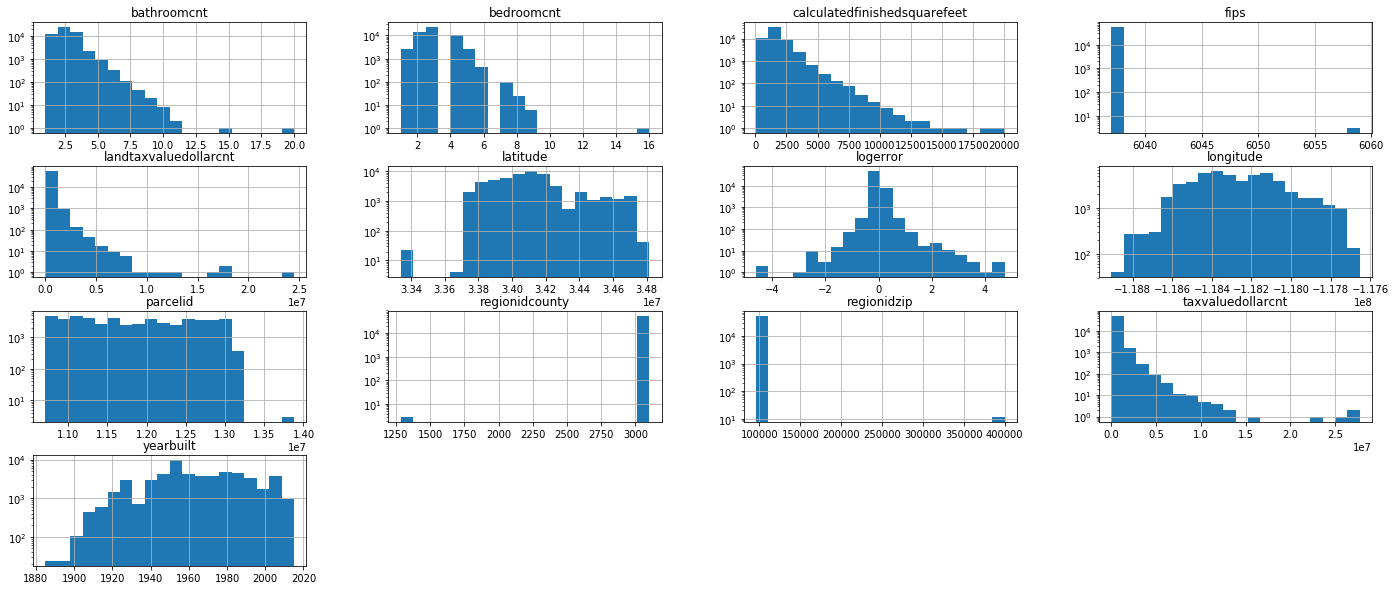

In [33]:
hist = df.hist(figsize = (24,10), bins=20, log=True)

##### Remove the extreme outliers

1. Error in regionidzip: anything above 99999 should be removed as those are not US zip codes
2. Others?

In [ ]:
Data types

In [ ]:
to_object = ['fips','parcelid','regionidcounty']

# year built to age

['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']
[10.0, 9.0, 13366.454999999907, 399675.0, 13306016.564395674, 10784552.77379539]


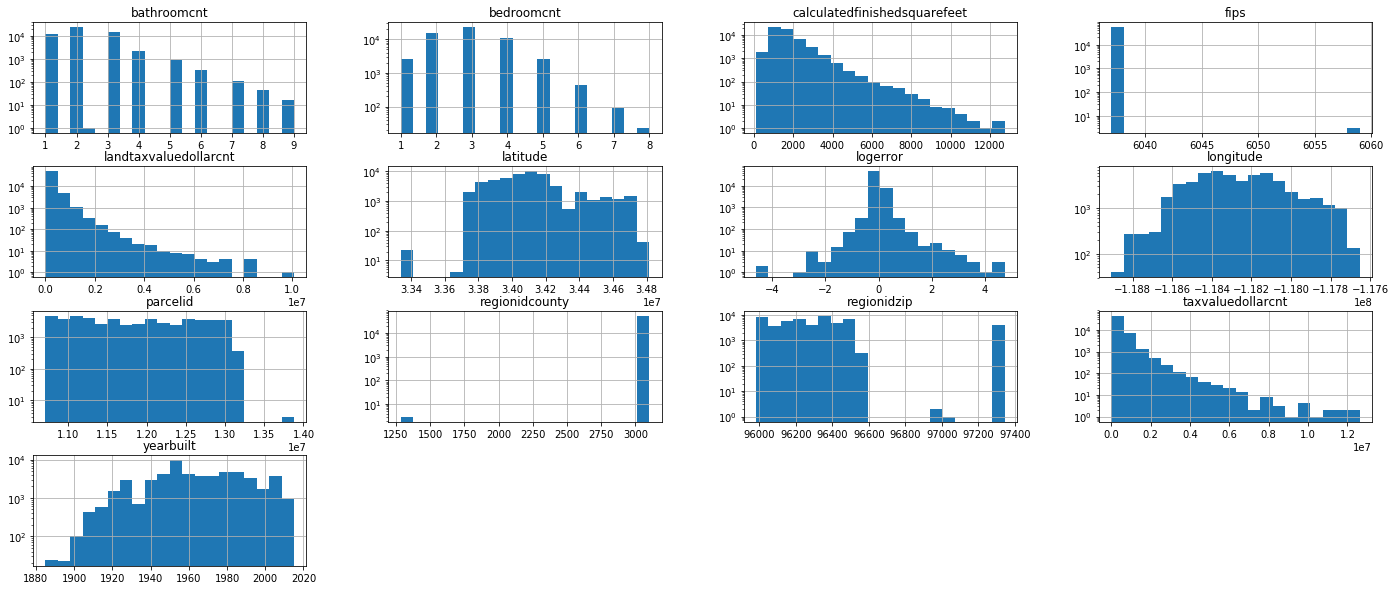

In [60]:
outliercols = list(df.drop(columns=['parcelid','fips','regionidcounty','logerror', 'yearbuilt', 'latitude', 'longitude']).select_dtypes('number').columns)

l = [None] * len(outliercols)
for i, col in enumerate(outliercols):
    l[i] = df[col].quantile(.9999)

for i, col in enumerate(outliercols):
    df = df[df[col] < l[i]]

df.hist(figsize = (24,10), bins=20, log=True)
plt.show()

In [64]:
train, test = train_test_split(df, random_state = seed)


In [ ]:
num_vars = list(train.drop(columns=[.select_dtypes('number').columns)
print('Scaling {}, and {}...'.format(', '.join(num_vars[:-1]), num_vars[:-1]))